## Шаг 1 - исследование данных и предобработка

In [131]:
import seaborn as sns
import pandas as pd
import numpy as np


df = pd.read_csv('data_1.csv', delimiter=';')
df.head()

,Год,Время года,Климат,Город,Страна,Способ охлаждения,Режим при смешанном типе охлаждения,Способ обогрева,Возраст,Пол,...,Скорость воздуха,Рост,Вес,Занавески,Вентилятор,Окно,Двери,Отопление,Среднемесячная температура на улице,Количество рекламаций
0,2011.0,Лето,Cубтропический океанический,Техас,США,Кондиционирование,NaN,NaN,22.0,NaN,...,0.26,NaN,NaN,1.0,1.0,NaN,NaN,NaN,28.9,0
1,2011.0,Лето,Cубтропический океанический,Техас,США,Кондиционирование,NaN,NaN,40.0,NaN,...,0.12,NaN,NaN,0.0,0.0,NaN,NaN,NaN,84.0,0
2,2011.0,Лето,Cубтропический океанический,Техас,США,Кондиционирование,NaN,NaN,42.0,NaN,...,0.08,NaN,NaN,0.0,0.0,NaN,NaN,NaN,32.8,0
3,2011.0,Лето,Cубтропический океанический,Техас,США,Кондиционирование,NaN,NaN,27.0,NaN,...,27.16,NaN,NaN,1.0,1.0,NaN,NaN,NaN,28.9,1
4,2011.0,Лето,Cубтропический океанический,Техас,США,Кондиционирование,NaN,NaN,46.0,NaN,...,63.83,NaN,NaN,1.0,1.0,NaN,NaN,NaN,32.8,0


In [132]:
# Привдение названия столбцов к формату PEP8
def to_pep_8():
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    

# К нужному типу данных (+ nan для категорий -1 0 1)
def dtype_to_int(cols: list):
    for col in cols:
        df[col] = df[col].astype(int)

        
def fill_nan_category(cols: list):
    for col in cols:  # repl (0, -1) (nan, 0) to int
        df[col] = df[col].replace(0., -1.)
        df[col] = df[col].fillna(0.)
        
    
# Correction values
def data_correction(): 
    replace_climat = {"Cубтроп океанич": "Cубтропический океанический"}
    replace_delta_temp = {"Холодн": "Холоднее", "Тепле": "Теплее"}
    
    df["климат"] = df["климат"].transform(
        lambda x: replace_climat[x] if x in replace_climat else x)
    df["предпочтительное_изменение_температуры"] = df["предпочтительное_изменение_температуры"].transform(
        lambda x: replace_delta_temp[x] if x in replace_climat else x)
    
    
# Fill nan and outliers
def fill_nan_and_outliers_values(column: str, group_col: list, high=None, low=None):  # group not included
    def fill_median_with_group():
        # if len(group_col):
        #     print(group_col)
        #     # df[column] = df.groupby(group_col, sort=False)[column].transform(lambda x: x.fillna(x.median()))
        #     df[column].fillna(df.groupby(group_col, dropna=False)[column].transform('median'), inplace=True)
        # else:
        #     df[column] = df[column].fillna(df[column].median())
        df[column] = df[column].fillna(df[column].median())
        # print(column, df[column].isnull().sum())
        
    Q1, Q3 = np.nanpercentile(df[column], [25, 75])
    
    # First fill median
    fill_median_with_group()
    
    # Second find outliers
    IQR  = Q3 - Q1
    High = Q3 + 3 * IQR if high is None else high
    Low  = Q1 - 3 * IQR if low is None else low 
    # print(column, (Low, High), (Q1, Q3))
    df[column] = df[column].where(df[column].between(Low, High), np.nan)

    # Next fill outliers
    fill_median_with_group()
    # print(column, df[column].isnull().sum(), df[column].unique())

In [137]:
to_pep_8()
data_correction()
print(list(df.columns))

# df["способ_охлаждения"] = (df["способ_охлаждения"].where(df["способ_охлаждения"] == "Смешанный")
#                            .transform(lambda x: x))

df.groupby("способ_охлаждения").apply(lambda x: pd.Series(dict(
    new=(x["способ_охлаждения"] == "Смешанный") + f' ({x["режим_при_смешанном_типе_охлаждения"]})')))
print(df["способ_охлаждения"].unique())

fill_nan_category(["занавески", "вентилятор", "окно", "двери", "отопление",
                   "ощущение_температуры_(bool)", "ощущение_движения_воздуха_(bool)"])

dtype_to_int(["год", "занавески", "вентилятор", "окно", "двери", "отопление",
              "ощущение_температуры_(bool)", "ощущение_движения_воздуха_(bool)"])


# вес рост возраст среднемесячная_температура_на_улице скорость_воздуха
# температура_воздуха_на_улице(*) температура_воздуха_в_помещении(*) оценка_комфорта[*]
fill_nan_and_outliers_values("вес", ["пол"])
fill_nan_and_outliers_values("рост", ["пол"])
fill_nan_and_outliers_values("возраст", ["пол"])
fill_nan_and_outliers_values("скорость_воздуха", [], low=0, high=10)
fill_nan_and_outliers_values("температура_воздуха_на_улице", ["страна", "время_года"])
fill_nan_and_outliers_values("температура_воздуха_в_помещении", ["страна", "время_года"], low=15, high=40)
fill_nan_and_outliers_values("среднемесячная_температура_на_улице", ["страна", "время_года"])
# df.groupby(["страна", "время_года"]).count()

['год', 'время_года', 'климат', 'город', 'страна', 'способ_охлаждения', 'режим_при_смешанном_типе_охлаждения', 'способ_обогрева', 'возраст', 'пол', 'ощущение_температуры', 'ощущение_температуры_(bool)', 'предпочтительное_изменение_температуры', 'ощущение_движения_воздуха_(bool)', 'предпочтительное_изменение_движения_воздуха', 'оценка_комфорта', 'утепление', 'температура_воздуха_в_помещении', 'температура_воздуха_на_улице', 'rh', 'скорость_воздуха', 'рост', 'вес', 'занавески', 'вентилятор', 'окно', 'двери', 'отопление', 'среднемесячная_температура_на_улице', 'количество_рекламаций']


KeyError: 'способ_охлаждения'

In [134]:
# Info
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 484 entries, 0 to 483
Data columns (total 30 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   год                                          484 non-null    int32  
 1   время_года                                   484 non-null    object 
 2   климат                                       484 non-null    object 
 3   город                                        484 non-null    object 
 4   страна                                       484 non-null    object 
 5   способ_охлаждения                            484 non-null    object 
 6   режим_при_смешанном_типе_охлаждения          337 non-null    object 
 7   способ_обогрева                              222 non-null    object 
 8   возраст                                      484 non-null    float64
 9   пол                                          412 non-null    object 
 10  ощ

,год,возраст,ощущение_температуры,ощущение_температуры_(bool),ощущение_движения_воздуха_(bool),оценка_комфорта,утепление,температура_воздуха_в_помещении,температура_воздуха_на_улице,rh,скорость_воздуха,рост,вес,занавески,вентилятор,окно,двери,отопление,среднемесячная_температура_на_улице,количество_рекламаций
count,484.000000,484.000000,484.000000,484.000000,484.000000,215.000000,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000
mean,2011.033058,40.834711,0.203306,0.578512,0.206612,4.772093,0.634587,25.023140,24.100620,52.973760,0.148099,165.556198,65.208678,0.004132,0.016529,-0.291322,-0.204545,0.092975,24.988843,0.105372
std,0.922988,10.172098,1.091976,0.816518,0.605938,1.261161,0.253103,2.759505,0.231789,13.036204,0.396985,5.242597,7.689621,0.386072,0.549549,0.701851,0.532096,0.393572,5.859935,0.440276
min,2010.000000,22.000000,-3.000000,-1.000000,-1.000000,1.000000,0.360000,16.200000,22.800000,23.800000,0.000000,134.600000,42.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,8.500000,0.000000
25%,2010.000000,35.000000,0.000000,1.000000,0.000000,4.000000,0.460000,23.800000,24.100000,42.775000,0.060000,165.100000,65.000000,0.000000,0.000000,-1.000000,-1.000000,0.000000,22.000000,0.000000
50%,2011.000000,42.000000,0.000000,1.000000,0.000000,5.000000,0.590000,24.600000,24.100000,53.750000,0.090000,165.100000,65.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22.000000,0.000000
75%,2012.000000,45.000000,1.000000,1.000000,1.000000,6.000000,0.700000,25.700000,24.100000,62.325000,0.140000,165.100000,65.000000,0.000000,0.000000,0.000000,0.000000,0.000000,30.400000,0.000000
max,2012.000000,65.000000,3.000000,1.000000,1.000000,6.000000,2.080000,37.400000,25.900000,85.100000,8.200000,190.500000,110.000000,1.000000,1.000000,1.000000,1.000000,1.000000,38.100000,3.000000


In [135]:
# Value counts
for col in df.columns:
    print(col, df[col].value_counts(dropna=False))

год год
2012    214
2010    198
2011     72
Name: count, dtype: int64
время_года время_года
Лето     372
Зима      81
Весна     18
Осень     13
Name: count, dtype: int64
климат климат
Cубтропический океанический         270
Тропическая влажная саванна          77
Жаркий полузасушливый                70
Влажный субтропический муссонный     35
Субтропическое высокогорье           32
Name: count, dtype: int64
город город
Сидней        198
Техас          72
Ченнай         51
Ахмедабад      38
Дели           35
Шимла          32
Хайдарабад     32
Бангалор       26
Name: count, dtype: int64
страна страна
Индия        214
Австралия    198
США           72
Name: count, dtype: int64
способ_охлаждения способ_охлаждения
Смешанный            337
Кондиционирование    114
Вентиляция            33
Name: count, dtype: int64
режим_при_смешанном_типе_охлаждения режим_при_смешанном_типе_охлаждения
Кондиционирование    237
NaN                  147
Вентиляция           100
Name: count, dtype: int64
способ_

In [136]:
# Show sorted numeric
for col in df.select_dtypes(include='number').columns:
    vals = df[col]
    print(col, (vals.min(), vals.quantile(0.05), [vals.median(), vals.mean()],  vals.quantile(0.95), vals.max()),
          df[col].sort_values().tolist(), sep='\n', end='\n\n')

год
(2010, 2010.0, [2011.0, 2011.0330578512396], 2012.0, 2012)
[2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 

In [116]:
# Show sns
sub_df = df.select_dtypes(include='number')
print(df.columns)
sub_df = df[['год', 'возраст', 'рост', 'вес', 'температура_воздуха_на_улице', 'среднемесячная_температура_на_улице',
             'температура_воздуха_в_помещении', 'оценка_комфорта',]]
sub_df.corr(method="pearson").style.background_gradient(cmap="cividis")  # RdYlGn

Index(['год', 'время_года', 'климат', 'город', 'страна', 'способ_охлаждения',
       'режим_при_смешанном_типе_охлаждения', 'способ_обогрева', 'возраст',
       'пол', 'ощущение_температуры', 'ощущение_температуры_(bool)',
       'предпочтительное_изменение_температуры',
       'ощущение_движения_воздуха_(bool)',
       'предпочтительное_изменение_движения_воздуха', 'оценка_комфорта',
       'утепление', 'температура_воздуха_в_помещении',
       'температура_воздуха_на_улице', 'rh', 'скорость_воздуха', 'рост', 'вес',
       'занавески', 'вентилятор', 'окно', 'двери', 'отопление',
       'среднемесячная_температура_на_улице', 'количество_рекламаций'],
      dtype='object')


,год,возраст,рост,вес,температура_воздуха_на_улице,среднемесячная_температура_на_улице,температура_воздуха_в_помещении,оценка_комфорта
год,1.000000,-0.228536,0.091350,0.028489,-0.000096,0.070518,0.316515,0.325765
возраст,-0.228536,1.000000,-0.133604,0.021061,0.032007,-0.058378,-0.034298,0.077740
рост,0.091350,-0.133604,1.000000,0.564093,-0.000233,0.006178,0.018118,0.109721
вес,0.028489,0.021061,0.564093,1.000000,-0.000073,-0.009203,-0.073133,0.021341
температура_воздуха_на_улице,-0.000096,0.032007,-0.000233,-0.000073,1.000000,0.027189,0.127707,-0.021937
среднемесячная_температура_на_улице,0.070518,-0.058378,0.006178,-0.009203,0.027189,1.000000,0.101708,-0.167358
температура_воздуха_в_помещении,0.316515,-0.034298,0.018118,-0.073133,0.127707,0.101708,1.000000,-0.011570
оценка_комфорта,0.325765,0.077740,0.109721,0.021341,-0.021937,-0.167358,-0.011570,1.000000


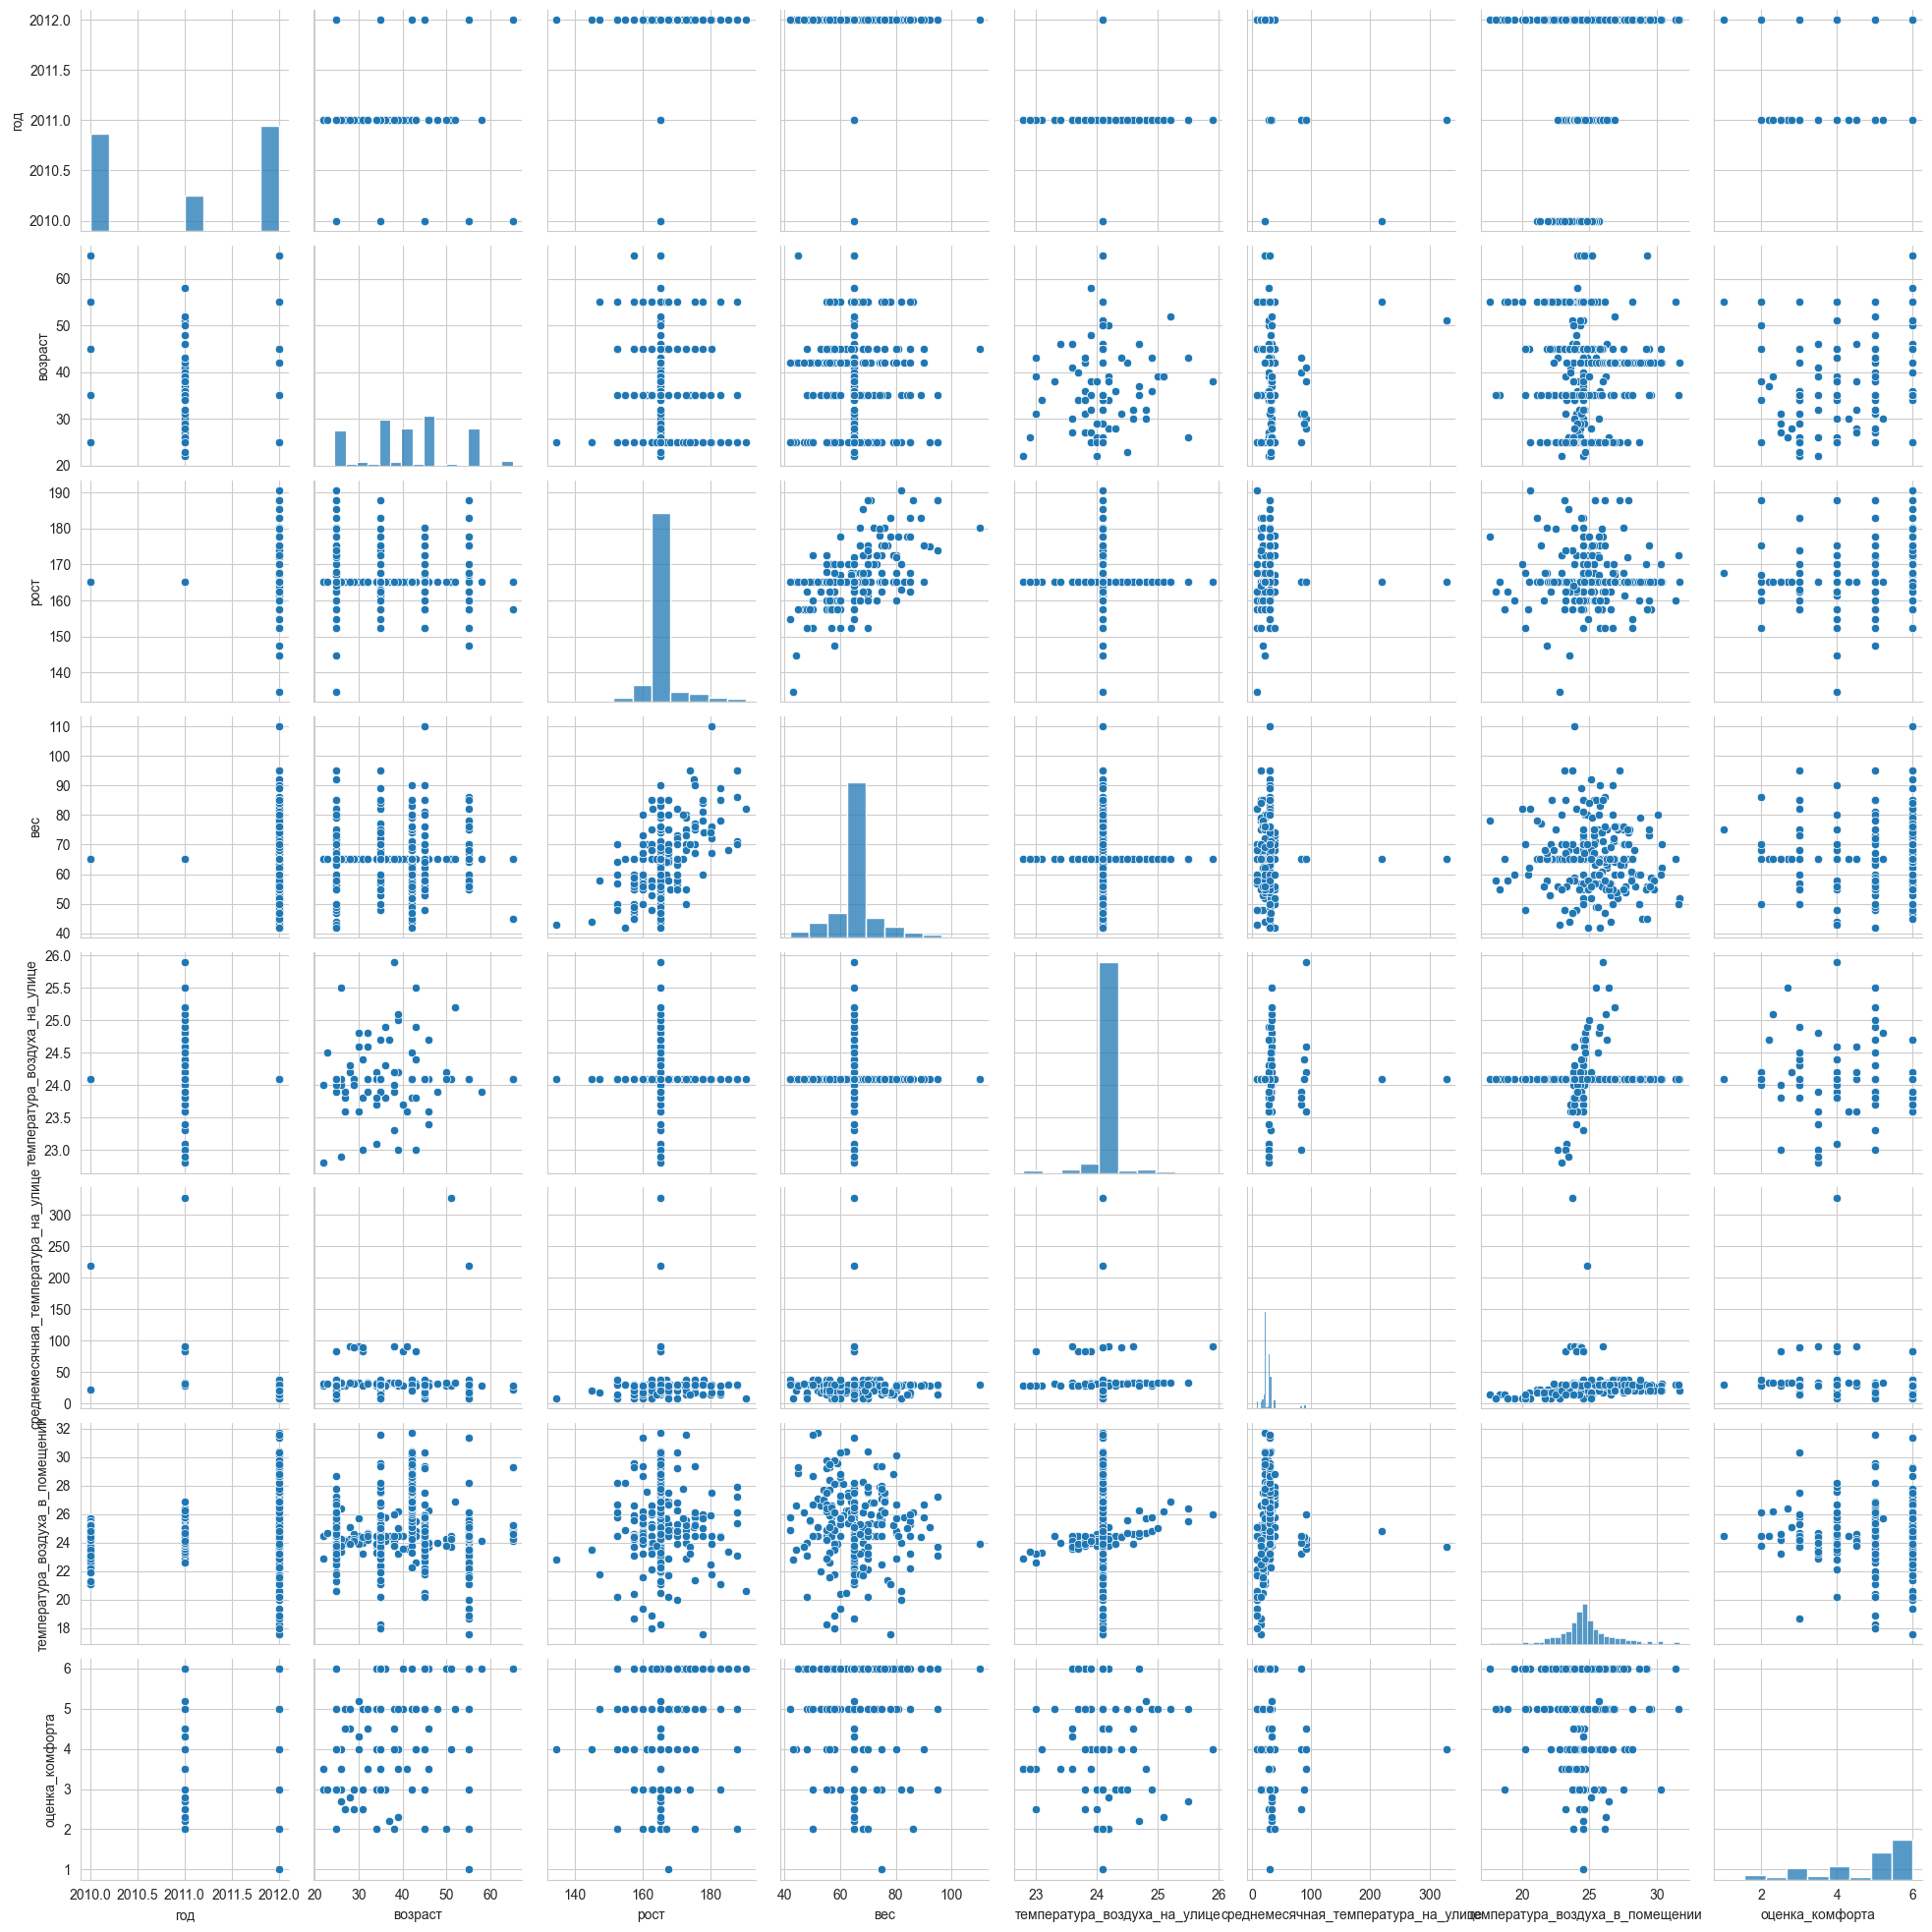

In [117]:
sns.pairplot(sub_df)

### Save

In [ ]:
df.to_csv('data_2.csv', index=False, sep=';')